In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# 1. ЗАВАНТАЖЕННЯ ТА ОЧИЩЕННЯ
df = pd.read_csv('applications(2.0).csv')
industries = pd.read_csv('industries(2.0).csv')

In [16]:
# Видалення дублікатів та заповнення пропусків
df = df.drop_duplicates(subset='applicant_id')
df['External Rating'] = df['External Rating'].fillna(0)
df['Education level'] = df['Education level'].fillna('Середня')

In [17]:
# Об'єднання з довідником індустрій
df = df.merge(industries[['Industry', 'Score']], on='Industry', how='left')
df['Score'] = df['Score'].fillna(0)

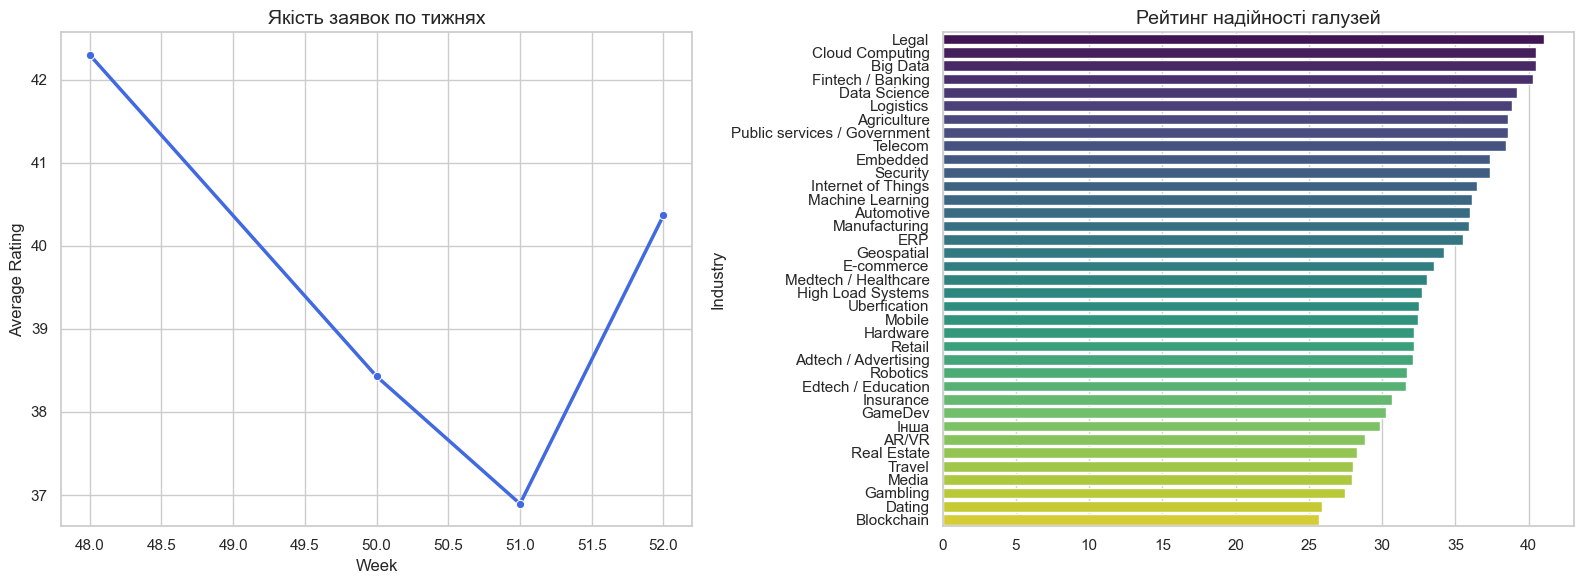

Аналіз завершено успішно!


In [26]:
# 1. ПІДГОТОВКА ТА РОЗРАХУНОК (ОДНИМ БЛОКОМ)
df['Applied at'] = pd.to_datetime(df['Applied at'], errors='coerce')

# Розрахунок балів
age_score = ((df['Age'] >= 35) & (df['Age'] <= 55)) * 20
weekday_score = (df['Applied at'].dt.dayofweek < 5) * 20
married_score = (df['Marital status'].str.lower() == 'одружений') * 20
kyiv_score = df['Location'].str.contains('київ', case=False, na=False) * 10
external_rating_score = (df['External Rating'] >= 7) * 20 - (df['External Rating'] <= 2) * 20
industry_score = df['Score'].fillna(0)

# Запис фінального рейтингу
df['Rating'] = 0
valid_mask = df['Amount'].notna() & (df['External Rating'] != 0)
df.loc[valid_mask, 'Rating'] = (
    age_score + weekday_score + married_score + 
    kyiv_score + industry_score + external_rating_score
)[valid_mask]

# 2. АНАЛІТИКА
accepted = df[df['Rating'] > 0].copy()
accepted['Week'] = accepted['Applied at'].dt.isocalendar().week
weekly_avg = accepted.groupby('Week', as_index=False)['Rating'].mean().rename(columns={'Rating': 'Average Rating'})

# 3. ВІЗУАЛІЗАЦІЯ (БЕЗ ПОМИЛОК FUTUREWARNING)
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Графік тренду
sns.lineplot(ax=axes[0], data=weekly_avg, x='Week', y='Average Rating', marker='o', color='royalblue', linewidth=2.5)
axes[0].set_title('Якість заявок по тижнях', fontsize=14)

# Графік індустрій
industry_res = accepted.groupby('Industry')['Rating'].mean().sort_values(ascending=False)
sns.barplot(
    ax=axes[1], x=industry_res.values, y=industry_res.index, 
    hue=industry_res.index, palette='viridis', legend=False
)
axes[1].set_title('Рейтинг надійності галузей', fontsize=14)

plt.tight_layout()
plt.show()

print("Аналіз завершено успішно!")